<a href="https://colab.research.google.com/github/YasudaKaito/pytorch_book_akaishi/blob/main/ch08_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- MNISTデータは[1, 28, 28]の3階テンソル
  - 最初の1は色次元(濃淡)
- 5章（単回帰）や7章（多値分類）の線形関数が一つのネットワークは「ニューラルネットワーク」
- 線形関数が2層以上の、隠れ層があるものが「ディープラーニング」

In [1]:
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import numpy as np

In [4]:
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [5]:
# テンソルをGPUに送る
x = x.to(device)
print(x.device)
print(y.device)

cuda:0
cpu


In [6]:
# GPUとCPUの間で演算するとエラー
z = x * y

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

- バッチ学習
  - 学習データ全件でまとめて勾配計算する
- ミニバッチ学習
  - サブセットで勾配計算する
- `DataSet`: データ入手
- `Transforms`: データ加工
- `DataLoader`: ミニバッチ生成


In [7]:
import torchvision.datasets as datasets

In [8]:
# ダウンロード先
data_root = "./data"
train_set0 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 100551205.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82573751.75it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31911201.84it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13021550.76it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 Apr  6 01:01 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 Apr  6 01:01 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 Apr  6 01:01 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 Apr  6 01:01 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 Apr  6 01:01 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 Apr  6 01:01 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 Apr  6 01:01 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 Apr  6 01:01 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 Apr  6 01:01 train-labels-idx1-ubyte.gz


In [10]:
print(len(train_set0))
image, label = train_set0[0]
print(type(image))
print(type(label))

60000
<class 'PIL.Image.Image'>
<class 'int'>


In [11]:
import matplotlib.pyplot as plt

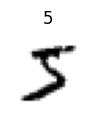

In [13]:
plt.figure(figsize=(1, 1))
plt.title(f"{label}")
plt.imshow(image, cmap="gray_r")
plt.axis("off")
plt.show()

In [14]:
import torchvision.transforms as transforms

In [15]:
transform1 = transforms.Compose([
    transforms.ToTensor(),
])

In [16]:
train_set1 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform1,
)

In [17]:
image, label = train_set1[0]
print(type(image))
print(image.shape)
print(image.data.min())
print(image.data.max())

<class 'torch.Tensor'>
torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)


In [18]:
# 値の区間が[0, 1]だが、これを[-1, 1]に変換する. 多少精度が向上する
# Normalize(μ, σ)により X = (x-μ) / σ に変換する
# μ=σ=0.5にすると[-1, 1]に変換できる
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform2,
)

In [19]:
image, label = train_set2[0]
print(image.shape)
print(image.data.min())
print(image.data.max())

torch.Size([1, 28, 28])
tensor(-1.)
tensor(1.)


In [20]:
# Lambda により (1, 28, 28) -> (784) に一次元にする
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set = datasets.MNIST(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
test_set = datasets.MNIST(
    root=data_root,
    train=False,
    download=True,
    transform=transform,
)

In [21]:
from torch.utils.data import DataLoader

In [22]:
batch_size = 500
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
)

In [23]:
# データ総数60000 / バッチサイズ500 = 120
print(len(train_loader))
# 最初の1セットを確認
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


In [25]:
image, label = train_set[0]
print(image.shape)
n_input = image.shape[0]

torch.Size([784])


In [26]:
n_output = 10
n_hidden = 128

In [27]:
import torch.nn as nn

In [28]:
# 入力: (n, 784) -> ×重み: (784, 128) -> (n, 128) -> ×重み: (128, 10) -> (n, 10)
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden) -> None:
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        # 損失関数側に softmax が含まれるので、Net側では不要
        return self.l2(x2)

In [32]:
import torch.optim as optim

# 初期化処理
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

lr = 0.01
net = Net(n_input, n_output, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 100
# 評価結果記録用
history = np.zeros((0,5))

In [33]:
from tqdm.notebook import tqdm

for epoch in range(num_epochs):
    # 1エポックあたりの正解数
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの累積損失
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    # 1エポックにつき全データをすべて見て勾配を計算する
    for inputs, labels in tqdm(train_loader):
        # 1バッチあたりのデータ件数 500
        train_batch_size = len(labels)
        n_train += train_batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # (500, 784) -> (500, 10)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 予測ラベル
        # (500, 10) テンソルの列方向の最大値のインデックス
        predicted = torch.max(outputs, 1)[1]
        train_loss += loss.item() * train_batch_size
        n_train_acc += (predicted == labels).sum().item()

    for inputs_test, labels_test in tqdm(test_loader):
        test_batch_size = len(labels_test)
        n_test += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # (500, 784) -> (500, 10)
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)
        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]
        # 平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        val_loss +=  loss_test.item() * test_batch_size
        n_val_acc +=  (predicted_test == labels_test).sum().item()

    # 1エポックごとに精度計算
    # 1エポック、すなわち60000データ全部の平均を出す
    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_test
    # 1エポックごとに損失計算
    # 1エポック、すなわち60000データ全部の平均を出す
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_test
    # 結果表示
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f}, val_acc: {val_acc:.5f}')
    # 記録
    item = np.array([epoch+1 , ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.82932 acc: 0.56958 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.03888 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87920


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.45883 acc: 0.87878 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39176 acc: 0.89065 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.37876 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36812 acc: 0.89592 val_loss: 0.34868, val_acc: 0.90160


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35910 acc: 0.89783 val_loss: 0.34089, val_acc: 0.90220


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.33336, val_acc: 0.90490


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.34477 acc: 0.90135 val_loss: 0.32806, val_acc: 0.90570


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33860 acc: 0.90310 val_loss: 0.32334, val_acc: 0.90710


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.33333 acc: 0.90412 val_loss: 0.31807, val_acc: 0.90790


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32843 acc: 0.90520 val_loss: 0.31445, val_acc: 0.90930


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.32380 acc: 0.90700 val_loss: 0.31076, val_acc: 0.91090


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31950 acc: 0.90807 val_loss: 0.30586, val_acc: 0.91190


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31587 acc: 0.90905 val_loss: 0.30281, val_acc: 0.91240


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.31199 acc: 0.91032 val_loss: 0.29965, val_acc: 0.91520


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30842 acc: 0.91098 val_loss: 0.29713, val_acc: 0.91430


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30507 acc: 0.91195 val_loss: 0.29432, val_acc: 0.91570


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.30190 acc: 0.91320 val_loss: 0.29123, val_acc: 0.91770


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29883 acc: 0.91403 val_loss: 0.28884, val_acc: 0.91700


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29597 acc: 0.91492 val_loss: 0.28646, val_acc: 0.91820


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.29311 acc: 0.91662 val_loss: 0.28365, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.29027 acc: 0.91698 val_loss: 0.28185, val_acc: 0.92000


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28765 acc: 0.91798 val_loss: 0.28041, val_acc: 0.91950


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28510 acc: 0.91858 val_loss: 0.27748, val_acc: 0.92110


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.28233 acc: 0.91958 val_loss: 0.27485, val_acc: 0.92180


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27989 acc: 0.92040 val_loss: 0.27255, val_acc: 0.92120


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27763 acc: 0.92067 val_loss: 0.27010, val_acc: 0.92210


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27513 acc: 0.92102 val_loss: 0.26897, val_acc: 0.92410


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.27278 acc: 0.92242 val_loss: 0.26668, val_acc: 0.92430


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.27048 acc: 0.92280 val_loss: 0.26462, val_acc: 0.92360


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26828 acc: 0.92358 val_loss: 0.26279, val_acc: 0.92440


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26597 acc: 0.92403 val_loss: 0.26075, val_acc: 0.92550


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26357 acc: 0.92455 val_loss: 0.25918, val_acc: 0.92580


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.26157 acc: 0.92565 val_loss: 0.25719, val_acc: 0.92660


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25919 acc: 0.92603 val_loss: 0.25558, val_acc: 0.92630


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25715 acc: 0.92695 val_loss: 0.25282, val_acc: 0.92720


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25496 acc: 0.92765 val_loss: 0.25100, val_acc: 0.92940


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25292 acc: 0.92775 val_loss: 0.24995, val_acc: 0.92800


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.25096 acc: 0.92845 val_loss: 0.24743, val_acc: 0.92930


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24867 acc: 0.92937 val_loss: 0.24636, val_acc: 0.93070


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24664 acc: 0.92965 val_loss: 0.24402, val_acc: 0.93100


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24463 acc: 0.93042 val_loss: 0.24264, val_acc: 0.93060


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.24266 acc: 0.93060 val_loss: 0.24012, val_acc: 0.93220


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.24070 acc: 0.93147 val_loss: 0.23928, val_acc: 0.93250


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23872 acc: 0.93212 val_loss: 0.23708, val_acc: 0.93300


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23680 acc: 0.93225 val_loss: 0.23567, val_acc: 0.93290


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23485 acc: 0.93345 val_loss: 0.23360, val_acc: 0.93310


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23294 acc: 0.93442 val_loss: 0.23177, val_acc: 0.93430


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.23101 acc: 0.93478 val_loss: 0.22988, val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22909 acc: 0.93517 val_loss: 0.22863, val_acc: 0.93460


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22729 acc: 0.93568 val_loss: 0.22641, val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22537 acc: 0.93643 val_loss: 0.22547, val_acc: 0.93580


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22367 acc: 0.93693 val_loss: 0.22324, val_acc: 0.93600


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.22190 acc: 0.93743 val_loss: 0.22190, val_acc: 0.93630


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.22019 acc: 0.93808 val_loss: 0.22011, val_acc: 0.93690


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21845 acc: 0.93840 val_loss: 0.21884, val_acc: 0.93770


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21653 acc: 0.93903 val_loss: 0.21656, val_acc: 0.93720


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21485 acc: 0.93970 val_loss: 0.21577, val_acc: 0.93910


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21321 acc: 0.94003 val_loss: 0.21334, val_acc: 0.93830


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.21152 acc: 0.94050 val_loss: 0.21216, val_acc: 0.93890


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20996 acc: 0.94112 val_loss: 0.21143, val_acc: 0.93960


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20826 acc: 0.94157 val_loss: 0.20924, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20673 acc: 0.94210 val_loss: 0.20716, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20500 acc: 0.94235 val_loss: 0.20682, val_acc: 0.94000


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20353 acc: 0.94292 val_loss: 0.20485, val_acc: 0.94080


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.20198 acc: 0.94355 val_loss: 0.20380, val_acc: 0.94120


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.20053 acc: 0.94373 val_loss: 0.20211, val_acc: 0.94110


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19892 acc: 0.94420 val_loss: 0.20087, val_acc: 0.94240


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19754 acc: 0.94453 val_loss: 0.19895, val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19587 acc: 0.94513 val_loss: 0.19793, val_acc: 0.94270


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19454 acc: 0.94533 val_loss: 0.19671, val_acc: 0.94330


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19313 acc: 0.94565 val_loss: 0.19520, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.19163 acc: 0.94620 val_loss: 0.19405, val_acc: 0.94430


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.19041 acc: 0.94635 val_loss: 0.19304, val_acc: 0.94360


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18891 acc: 0.94713 val_loss: 0.19190, val_acc: 0.94340


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18764 acc: 0.94737 val_loss: 0.19039, val_acc: 0.94470


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18620 acc: 0.94795 val_loss: 0.18892, val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18487 acc: 0.94812 val_loss: 0.18786, val_acc: 0.94500


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18358 acc: 0.94818 val_loss: 0.18690, val_acc: 0.94610


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18228 acc: 0.94888 val_loss: 0.18556, val_acc: 0.94620


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.18101 acc: 0.94955 val_loss: 0.18461, val_acc: 0.94570


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17976 acc: 0.94977 val_loss: 0.18364, val_acc: 0.94700


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17846 acc: 0.95025 val_loss: 0.18184, val_acc: 0.94720


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17737 acc: 0.95042 val_loss: 0.18089, val_acc: 0.94730


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17612 acc: 0.95097 val_loss: 0.17952, val_acc: 0.94780


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17488 acc: 0.95118 val_loss: 0.17919, val_acc: 0.94800


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17383 acc: 0.95140 val_loss: 0.17744, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17264 acc: 0.95175 val_loss: 0.17635, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.17143 acc: 0.95218 val_loss: 0.17556, val_acc: 0.94890


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.17035 acc: 0.95275 val_loss: 0.17470, val_acc: 0.94810


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16915 acc: 0.95272 val_loss: 0.17389, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16811 acc: 0.95332 val_loss: 0.17414, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16696 acc: 0.95357 val_loss: 0.17145, val_acc: 0.94830


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.16583 acc: 0.95408 val_loss: 0.17067, val_acc: 0.94960


* 著者の環境ではバッチサイズが200, 100, 50 と小さくなるほど精度が高くなったという
  * 参考: https://dajiro.com/entry/2020/04/15/221414
